# Load Data and Word-Embedding Models

In [1]:
import os
import re
import json
import gensim   
import gensim.downloader as api
import torch.optim as optim
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score

# Load data
train_data = json.load(open('NER_train.json', 'r'))
val_data = json.load(open('NER_val.json', 'r'))
test_data = json.load(open('NER_test.json', 'r'))

# Load pre-trained word2vec model
word2vec = api.load("word2vec-google-news-300")
glove = api.load("glove-wiki-gigaword-300")
fasttext = api.load("fasttext-wiki-news-subwords-300")

In [2]:
def get_embedding(word, embedding_model, size):
    try:
        # print('word2vec')
        return torch.tensor(embedding_model[word])
    except:
        # print('ones')
        return torch.ones(size)

# GRU Implementation

In [3]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = 1
        self.gru = nn.GRU(input_size, hidden_size, self.n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(x.device)  # Initialize hidden state
        out, _ = self.gru(x, h0)
        out = self.fc(out)
        return out


# Training and Validation Code

In [4]:
def clean_word(word):
    import string
    clean_word = word.translate(str.maketrans('', '', string.punctuation))
    clean_word = clean_word.strip()
    if not clean_word:
        return ' ' * len(word)
    else:
        return clean_word
    
def training_and_validation(model, embedding_model, train_data, val_data, criterion, optimizer,
            device='cuda', epochs=10):
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    output_size = len(label_mapping)
    
    model = model.to(device)
    training_loss, validation_loss = [], []
    training_f1, validation_f1 = [], []
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')

        ###################### TRAINING STEP ####################
        model.train()
        train_actual = []
        train_predicted = []
        train_loss = 0
        
        for _, data in train_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            #  Convert text to embeddings
            embedded_text = torch.stack([get_embedding(clean_word(token), embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            # Compute loss
            loss = criterion(outputs.view(-1, output_size), targets)
            train_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            train_actual.extend(targets.tolist())     
            train_loss += loss.item()       
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        train_loss = train_loss / len(train_data)
        accuracy = accuracy_score(train_actual, train_predicted)
        f1 = f1_score(train_actual, train_predicted, average="macro")
        training_loss.append(train_loss)
        training_f1.append(f1)
        print(f"Training: Loss: {train_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
        
        ###################### VALIDATION STEP ####################
        model.eval()
        validation_actual = []
        validation_predicted = []
        val_loss = 0
        with torch.no_grad():
            for _, data in val_data.items():
                text = data["text"]
                pattern = r'[ ]+'
                text = re.split(pattern, text)
                labels = data["labels"]
                #  Convert text to embeddings
                embedded_text = torch.stack([get_embedding(clean_word(token), embedding_model, 300) for token in text])
                embedded_text = embedded_text.unsqueeze(0)
                targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
                embedded_text, targets = embedded_text.to(device), targets.to(device)
                # Forward pass
                outputs = model(embedded_text)
                # Compute loss
                loss = criterion(outputs.view(-1, output_size), targets)
                validation_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
                validation_actual.extend(targets.tolist())     
                val_loss += loss.item()
            val_loss = val_loss / len(val_data)
            accuracy = accuracy_score(validation_actual, validation_predicted)
            f1 = f1_score(validation_actual, validation_predicted, average="macro")
            validation_loss.append(val_loss)
            validation_f1.append(f1)
            print(f"Validation: Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
    
    return training_loss, validation_loss, training_f1, validation_f1
        

# Fine-Tuning on Validation Data

In [5]:
def fine_tune(model, embedding_model, val_data,  criterion, optimizer, device='cuda', epochs=3):
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    output_size = len(label_mapping)
    model = model.to(device)
    model.train()
    
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        tuning_loss = 0
        actual = []
        predicted = []
        for _, data in val_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(clean_word(token), embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            # Compute loss
            loss = criterion(outputs.view(-1, output_size), targets)
            predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            actual.extend(targets.tolist())     
            tuning_loss += loss.item()       
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        tuning_loss = tuning_loss / len(val_data)
        accuracy = accuracy_score(actual, predicted)
        f1 = f1_score(actual, predicted, average="macro")
        print(f"FineTuning: Loss: {tuning_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}")
        

# Testing Code

In [6]:
def test(model, embedding_model, test_data, device='cuda', show_labelwise=False, plot=False):
    if type(model) == str:
        model = torch.load(model)
    label_mapping = {'O': 0, 'B_CASE_NUMBER': 1, 'I_CASE_NUMBER': 2, 'B_ORG': 3, 'I_ORG': 4, 'B_OTHER_PERSON': 5, 'I_OTHER_PERSON': 6, 'B_STATUTE': 7, 'I_STATUTE': 8, 'B_PROVISION': 9, 'I_PROVISION': 10, 'B_COURT': 11, 'I_COURT': 12, 'B_WITNESS': 13, 'B_PRECEDENT': 14, 'I_PRECEDENT': 15, 'B_DATE': 16, 'B_PETITIONER': 17, 'I_PETITIONER': 18, 'I_WITNESS': 19, 'B_GPE': 20, 'B_RESPONDENT': 21, 'I_RESPONDENT': 22, 'I_DATE': 23, 'B_JUDGE': 24, 'I_JUDGE': 25, 'I_GPE': 26}
    model = model.to(device)
    model.eval()
    test_actual = []
    test_predicted = []
    with torch.no_grad():
        for _, data in test_data.items():
            text = data["text"]
            pattern = r'[ ]+'
            text = re.split(pattern, text)
            labels = data["labels"]
            # Convert text to embeddings
            embedded_text = torch.stack([get_embedding(clean_word(token), embedding_model, 300) for token in text])
            embedded_text = embedded_text.unsqueeze(0)
            targets = torch.tensor([label_mapping[label] for label in labels], dtype=torch.long)
            embedded_text, targets = embedded_text.to(device), targets.to(device)
            # Forward pass
            outputs = model(embedded_text)
            test_predicted.extend(outputs.squeeze(0).argmax(dim=1).tolist())
            test_actual.extend(targets.tolist())     
        accuracy = accuracy_score(test_actual, test_predicted)
        f1 = f1_score(test_actual, test_predicted, average="macro")
    
    if show_labelwise:
        labelwise_predictions = {}
        for label in label_mapping:
            labelwise_predictions[label_mapping[label]] = {"actual": [], "predicted": []}
        for i in range(len(test_actual)):
            labelwise_predictions[test_actual[i]]["actual"].append(test_actual[i])
            labelwise_predictions[test_actual[i]]["predicted"].append(test_predicted[i])
        labelwise_f1, labelwise_accuracy = {}, {}
        for label in labelwise_predictions:
            labelwise_f1[label] = f1_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"], average="macro")
            labelwise_accuracy[label] = accuracy_score(labelwise_predictions[label]["actual"], labelwise_predictions[label]["predicted"])
        print('Labelwise F1 Scores:')
        print(labelwise_f1)
        print('Labelwise Accuracy Scores:')
        print(labelwise_accuracy)
        if plot:
            import matplotlib.pyplot as plt
            plt.bar(labelwise_f1.keys(), labelwise_f1.values())
            plt.xlabel('Label')
            plt.ylabel('F1 Score')
            plt.show()
    return accuracy, f1

In [7]:
def plot(training_loss, validation_loss, training_f1, validation_f1):
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(training_loss, label="Training Loss", color="blue")
    ax[0].plot(validation_loss, label="Validation Loss", color="red")
    ax[0].set_title("Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].legend()
    ax[1].plot(training_f1, label="Training F1", color="blue")
    ax[1].plot(validation_f1, label="Validation F1", color="red")
    ax[1].set_title("F1")
    ax[1].set_xlabel("Epoch")
    ax[1].legend()
    plt.show()

# Parameter Initialization

In [8]:
input_size = 300  # Embedding size
hidden_size = 128  # 128 Hidden size of the RNN
output_size = 27   # BIO encoding

# For Word2Vec Embeddings

In [9]:
gru_word2vec_model = GRUModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(gru_word2vec_model.parameters(), lr=0.001)
# optimizer = optim.SGD(gru_word2vec_model.parameters(), lr=0.1)   #momentum=0.9, 0.6, 0.1, 0.0

In [10]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            gru_word2vec_model, word2vec, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.3628, Accuracy: 0.9089, F1: 0.4226
Validation: Loss: 0.2701, Accuracy: 0.9292, F1: 0.5234
Epoch 2/10
Training: Loss: 0.2383, Accuracy: 0.9339, F1: 0.5948
Validation: Loss: 0.2500, Accuracy: 0.9344, F1: 0.6020
Epoch 3/10
Training: Loss: 0.1964, Accuracy: 0.9434, F1: 0.6701
Validation: Loss: 0.2469, Accuracy: 0.9354, F1: 0.6224
Epoch 4/10
Training: Loss: 0.1671, Accuracy: 0.9503, F1: 0.7145
Validation: Loss: 0.2518, Accuracy: 0.9357, F1: 0.6283
Epoch 5/10
Training: Loss: 0.1435, Accuracy: 0.9566, F1: 0.7509
Validation: Loss: 0.2604, Accuracy: 0.9341, F1: 0.6222
Epoch 6/10
Training: Loss: 0.1252, Accuracy: 0.9613, F1: 0.7797
Validation: Loss: 0.2687, Accuracy: 0.9330, F1: 0.6184
Epoch 7/10
Training: Loss: 0.1097, Accuracy: 0.9656, F1: 0.8067
Validation: Loss: 0.2850, Accuracy: 0.9312, F1: 0.6103
Epoch 8/10
Training: Loss: 0.0978, Accuracy: 0.9692, F1: 0.8283
Validation: Loss: 0.3001, Accuracy: 0.9297, F1: 0.6086
Epoch 9/10
Training: Loss: 0.0895, Accuracy: 0.9

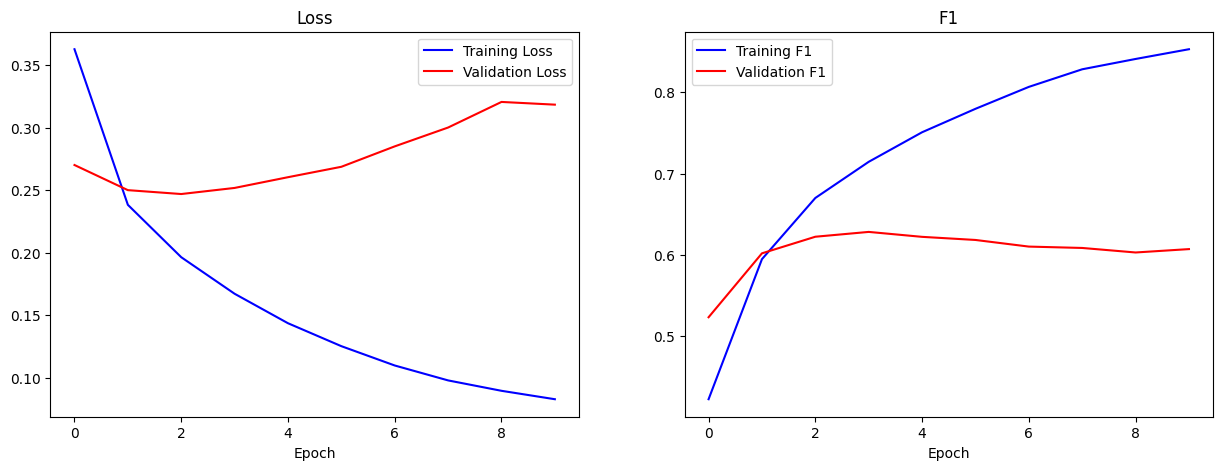

In [11]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [12]:
# fine_tune(gru_word2vec_model, word2vec, val_data, criterion, optimizer, device='cuda', epochs=2)

In [13]:
gru_word2vec_model = gru_word2vec_model.to('cpu')
torch.save(gru_word2vec_model, "t1_model3_word2vec.pt")

In [14]:
test_accuracy, test_f1 = test("t1_model3_word2vec.pt", word2vec, test_data, device='cuda', show_labelwise=True, plot=False)
print(("GRU with Word2Vec ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.03665067381881541, 1: 0.06011560693641619, 2: 0.07648114901256733, 3: 0.033936651583710405, 4: 0.046188574405278696, 5: 0.05843137254901961, 6: 0.05649717514124294, 7: 0.12265883217040029, 8: 0.1504297994269341, 9: 0.18633540372670807, 10: 0.29742289818335443, 11: 0.0937950937950938, 12: 0.10875216637781629, 13: 0.0907563025210084, 14: 0.048708048708048714, 15: 0.04337654125829908, 16: 0.22660098522167488, 17: 0.2, 18: 0.15555555555555556, 19: 0.07407407407407407, 20: 0.06447453255963895, 21: 0.08333333333333334, 22: 0.0, 23: 0.1875, 24: 0.25641025641025644, 25: 0.27777777777777773, 26: 0.13846153846153847}
Labelwise Accuracy Scores:
{0: 0.9793517844136926, 1: 0.4297520661157025, 2: 0.6191860465116279, 3: 0.2830188679245283, 4: 0.4290322580645161, 5: 0.5398550724637681, 6: 0.5128205128205128, 7: 0.7522522522522522, 8: 0.8224543080939948, 9: 0.872093023255814, 10: 0.8054919908466819, 11: 0.7303370786516854, 12: 0.7699386503067485, 13: 0.46551724137931033, 14: 

# For GloVe Embeddings

In [15]:
input_size, hidden_size, output_size = 300, 64, 27

gru_glove_model = GRUModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(gru_glove_model.parameters(), lr=0.001)
optimizer = optim.SGD(gru_glove_model.parameters(), lr=0.1)   #momentum=0.9, 0.6, 0.1, 0.0

In [16]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
            gru_glove_model, glove, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.5219, Accuracy: 0.8700, F1: 0.1932
Validation: Loss: 0.4440, Accuracy: 0.8829, F1: 0.2924
Epoch 2/10
Training: Loss: 0.4184, Accuracy: 0.8894, F1: 0.3181
Validation: Loss: 0.4122, Accuracy: 0.8896, F1: 0.3589
Epoch 3/10
Training: Loss: 0.3905, Accuracy: 0.8954, F1: 0.3739
Validation: Loss: 0.4001, Accuracy: 0.8930, F1: 0.3920
Epoch 4/10
Training: Loss: 0.3729, Accuracy: 0.8995, F1: 0.4010
Validation: Loss: 0.3955, Accuracy: 0.8938, F1: 0.4047
Epoch 5/10
Training: Loss: 0.3598, Accuracy: 0.9023, F1: 0.4167
Validation: Loss: 0.3934, Accuracy: 0.8939, F1: 0.4104
Epoch 6/10
Training: Loss: 0.3491, Accuracy: 0.9046, F1: 0.4290
Validation: Loss: 0.3938, Accuracy: 0.8937, F1: 0.4201
Epoch 7/10
Training: Loss: 0.3394, Accuracy: 0.9067, F1: 0.4439
Validation: Loss: 0.3941, Accuracy: 0.8932, F1: 0.4251
Epoch 8/10
Training: Loss: 0.3303, Accuracy: 0.9089, F1: 0.4548
Validation: Loss: 0.3960, Accuracy: 0.8925, F1: 0.4230
Epoch 9/10
Training: Loss: 0.3219, Accuracy: 0.9

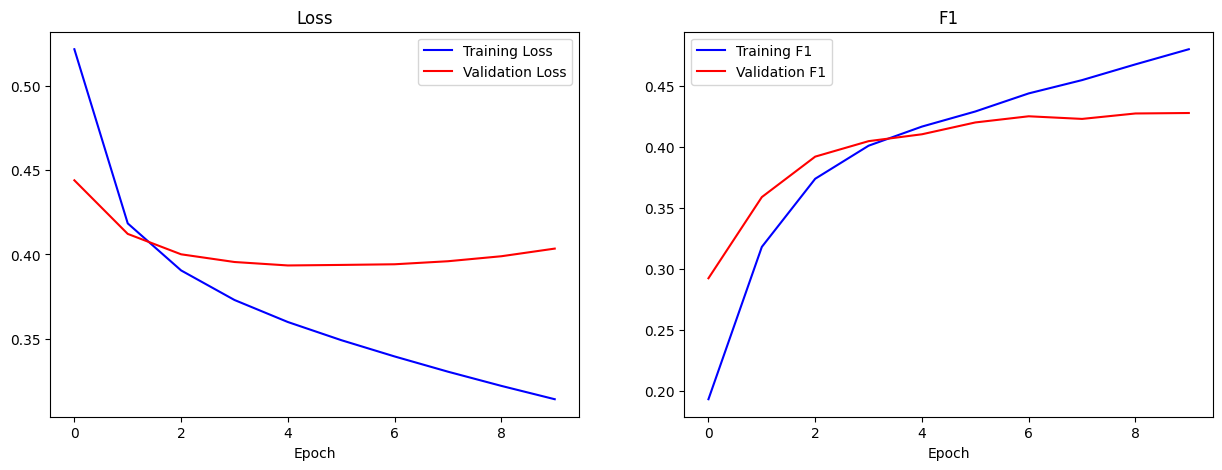

In [17]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [20]:
gru_glove_model = gru_glove_model.to('cpu')
torch.save(gru_glove_model, "t1_model3_glove.pt")

In [21]:
test_accuracy, test_f1 = test("t1_model3_glove.pt", glove, test_data, device='cuda', show_labelwise=True, plot=False)
print(("GRU with GloVe ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.03634385066745809, 1: 0.042577675489067886, 2: 0.08117443868739205, 3: 0.00078125, 4: 0.017553688141923436, 5: 0.022928994082840236, 6: 0.041064198958935795, 7: 0.07700831024930749, 8: 0.07452024093010225, 9: 0.07414634146341463, 10: 0.06508600650860065, 11: 0.029239766081871347, 12: 0.052950910093767234, 13: 0.04477611940298507, 14: 0.048666666666666664, 15: 0.05397366751269036, 16: 0.11397058823529413, 17: 0.1212121212121212, 18: 0.26666666666666666, 19: 0.13013698630136986, 20: 0.044743935309973046, 21: 0.0, 22: 0.07272727272727272, 23: 0.22872340425531915, 24: 0.0, 25: 0.0, 26: 0.02747252747252747}
Labelwise Accuracy Scores:
{0: 0.9632556445739258, 1: 0.30578512396694213, 2: 0.6831395348837209, 3: 0.006289308176100629, 4: 0.15161290322580645, 5: 0.2246376811594203, 6: 0.3641025641025641, 7: 0.6261261261261262, 8: 0.6945169712793734, 9: 0.5891472868217055, 10: 0.6407322654462243, 11: 0.2808988764044944, 12: 0.588957055214724, 13: 0.15517241379310345, 14: 0

# For FastText Embeddings

In [22]:
input_size, hidden_size, output_size = 300, 128, 27
gru_fasttext_model = GRUModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(gru_fasttext_model.parameters(), lr=0.001)
# optimizer = optim.SGD(gru_fasttext_model.parameters(), lr=0.1)   #momentum=0.9, 0.6, 0.1, 0.0

In [23]:
training_loss, validation_loss, training_f1, validation_f1 = training_and_validation(
        gru_fasttext_model, fasttext, train_data, val_data, criterion, optimizer, device='cuda', epochs=10)

Epoch 1/10
Training: Loss: 0.3827, Accuracy: 0.9039, F1: 0.3769
Validation: Loss: 0.2644, Accuracy: 0.9282, F1: 0.4652
Epoch 2/10
Training: Loss: 0.2410, Accuracy: 0.9320, F1: 0.5149
Validation: Loss: 0.2339, Accuracy: 0.9349, F1: 0.5346
Epoch 3/10
Training: Loss: 0.2041, Accuracy: 0.9407, F1: 0.5990
Validation: Loss: 0.2252, Accuracy: 0.9377, F1: 0.5743
Epoch 4/10
Training: Loss: 0.1781, Accuracy: 0.9473, F1: 0.6585
Validation: Loss: 0.2214, Accuracy: 0.9384, F1: 0.5956
Epoch 5/10
Training: Loss: 0.1563, Accuracy: 0.9524, F1: 0.6978
Validation: Loss: 0.2230, Accuracy: 0.9382, F1: 0.6044
Epoch 6/10
Training: Loss: 0.1389, Accuracy: 0.9571, F1: 0.7314
Validation: Loss: 0.2243, Accuracy: 0.9403, F1: 0.6309
Epoch 7/10
Training: Loss: 0.1230, Accuracy: 0.9613, F1: 0.7568
Validation: Loss: 0.2315, Accuracy: 0.9382, F1: 0.6280
Epoch 8/10
Training: Loss: 0.1106, Accuracy: 0.9648, F1: 0.7829
Validation: Loss: 0.2402, Accuracy: 0.9377, F1: 0.6325
Epoch 9/10
Training: Loss: 0.1004, Accuracy: 0.9

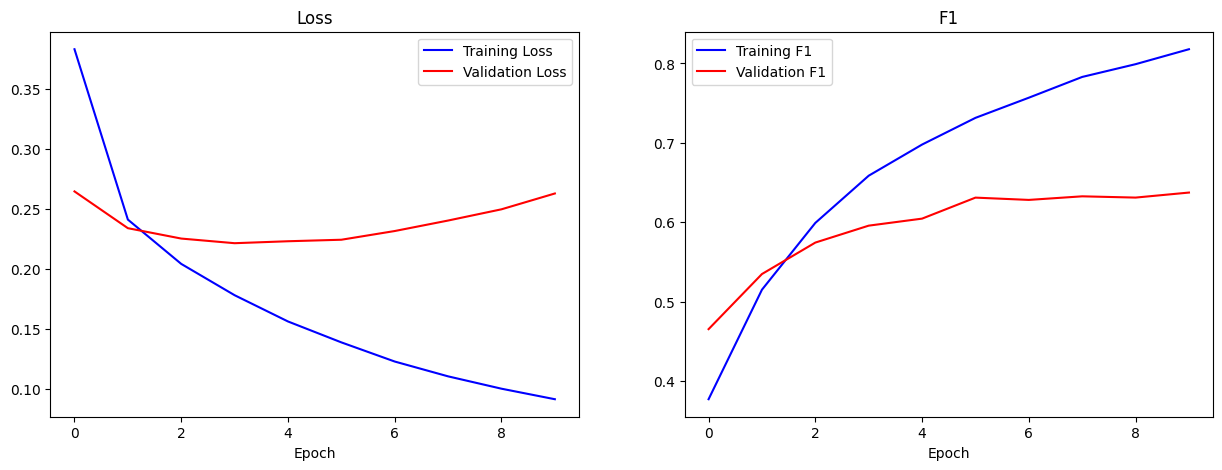

In [24]:
plot(training_loss, validation_loss, training_f1, validation_f1)

In [27]:
gru_fasttext_model = gru_fasttext_model.to('cpu')
torch.save(gru_fasttext_model, "t1_model3_fasttext.pt")

In [28]:
test_accuracy, test_f1 = test("t1_model3_fasttext.pt", fasttext, test_data, device='cuda', show_labelwise=True, plot=False)
print(("GRU with FastText ==> Accuracy: {:.4f}, F1: {:.4f}").format(test_accuracy, test_f1))

Labelwise F1 Scores:
{0: 0.038174380423018364, 1: 0.057647058823529405, 2: 0.08475711892797319, 3: 0.037991858887381276, 4: 0.047937810408119196, 5: 0.06556776556776557, 6: 0.08, 7: 0.08706240487062405, 8: 0.13931104356636273, 9: 0.15491009681881052, 10: 0.15238095238095237, 11: 0.09624911535739561, 12: 0.09422850412249706, 13: 0.06645569620253165, 14: 0.06539923954372624, 15: 0.055860098826436076, 16: 0.1855072463768116, 17: 0.2916666666666667, 18: 0.28070175438596495, 19: 0.08270676691729321, 20: 0.07151515151515152, 21: 0.08333333333333334, 22: 0.03333333333333333, 23: 0.18969072164948456, 24: 0.13636363636363635, 25: 0.4615384615384615, 26: 0.09180327868852459}
Labelwise Accuracy Scores:
{0: 0.9851784413692644, 1: 0.4049586776859504, 2: 0.7354651162790697, 3: 0.2641509433962264, 4: 0.3580645161290323, 5: 0.6485507246376812, 6: 0.6666666666666666, 7: 0.6441441441441441, 8: 0.7180156657963447, 9: 0.8682170542635659, 10: 0.8421052631578947, 11: 0.7640449438202247, 12: 0.73619631901840